### Goal is to classify what type of drum is being played at each onset, count number of onsets


In [235]:
from mido import MidiFile
import os
import pandas as pd
import scipy
from scipy.io.wavfile import read as wavread
import numpy as np
import matplotlib.pyplot as plt
import math
import librosa
import librosa.display
from scipy.signal import butter, lfilter

In [236]:
### Read Audio ###
def ToolReadAudio(cAudioFilePath):
    [samplerate, x] = wavread(cAudioFilePath)
    if x.dtype == 'float32':
        audio = x
    else:
        # change range to [-1,1)
        if x.dtype == 'uint8':
            nbits = 8
        elif x.dtype == 'int16':
            nbits = 16
        elif x.dtype == 'int32':
            nbits = 32
        audio = x / float(2**(nbits - 1))
    # special case of unsigned format
    if x.dtype == 'uint8':
        audio = audio - 1.
    return(samplerate, audio)

### Block Audio ###
def block_audio(x,blockSize,hopSize,fs):
    # allocate memory
    numBlocks = math.ceil(x.size / hopSize)
    xb = np.zeros([numBlocks, blockSize])
    # compute time stamps
    t = (np.arange(0, numBlocks) * hopSize) / fs
    x = np.concatenate((x, np.zeros(blockSize)),axis=0)
    for n in range(0, numBlocks):
        i_start = n * hopSize
        i_stop = np.min([x.size - 1, i_start + blockSize - 1])
        xb[n][np.arange(0,blockSize)] = x[np.arange(i_start, i_stop + 1)]
    return (xb,t)

In [239]:
samplerate,audio = ToolReadAudio('./groove/drummer1/session1/1_funk_80_beat_4-4.wav')
samplerate2,audio2 = ToolReadAudio('./groove/drummer1/session1/13_jazz-funk_116_fill_4-4.wav')
samplerate3,audio3 = ToolReadAudio('./groove/drummer1/session1/104_funk_95_fill_4-4.wav')

<ipython-input-236-e2d6b343da85>:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  [samplerate, x] = wavread(cAudioFilePath)


In [240]:
print(audio.shape)
print(samplerate)

(3835150, 2)
44100


### Adding the following features in case they are usable

In [241]:
def extract_spectral_centroid(xb, fs):
    length = xb.size
    window = np.hanning(length)
    xb = xb * window
    freq = np.abs(np.fft.fftfreq(length, 1/fs))
    mag = np.abs(np.fft.fft(xb))
    centroid = np.sum(mag * freq) / (np.sum(mag)+0.0001)
    return centroid

def extract_rms(xb):
    x_square = 0
    length = xb.size
    for i in range(length):
        x_square += xb[i]**2
    rms = math.sqrt(x_square/length)
    #print(rms)
    rms_db = 20 * math.log10(rms+0.00001)
    return rms_db

def extract_zerocrossingrate(xb):
    length = xb.size
    cross_boolean = np.diff(xb > 0)
    cross_ind = np.where(cross_boolean == True)[0]
    mean = cross_ind.size / (length-1)
    ZC = mean
    return ZC

def extract_spectral_crest(xb):
    length = xb.size
    window = np.hanning(length)
    xb = xb * window
    mag = np.abs(np.fft.fft(xb))
    max = np.max(mag)
    sum = np.sum(mag)
    spectral_crest = max / (sum+0.0001)
    return spectral_crest

def extract_spectral_flux(xb):
    length = xb.size
    window = np.hanning(length)
    xb = xb * window
    mag = np.abs(np.fft.fft(xb))
    diff = np.abs(mag[:-1] - mag[1:])
    spectral_flux = np.sqrt(np.sum(diff ** 2)) / mag.size
    return spectral_flux


def extract_features(x, blockSize, hopSize, fs):
    xb,t = block_audio(x, blockSize, hopSize, fs)
    block_num = math.ceil(x.size / hopSize)
    features = np.zeros([5, block_num])

    for i in range(0,block_num):
        # Spectral Centroid
        features[0][i] = extract_spectral_centroid(xb[i], fs)
        # RMS
        features[1][i] = extract_rms(xb[i])
        # Zero Crossing
        features[2][i] = extract_zerocrossingrate(xb[i])
        # Spectral Crest Factor
        features[3][i] = extract_spectral_crest(xb[i])
        # Spectral Flux
        features[4][i] = extract_spectral_flux(xb[i])
    #print(features[0].size)
    return features

In [242]:
myfeats = extract_features(audio[:,1], 1024, 512, samplerate);
print(myfeats.shape)

(5, 7491)


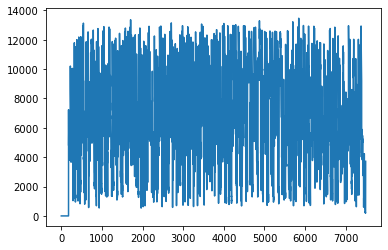

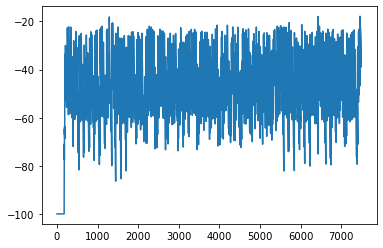

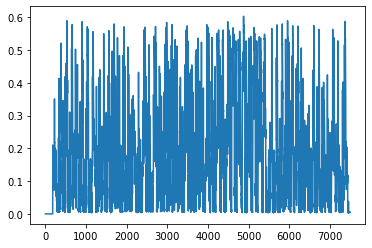

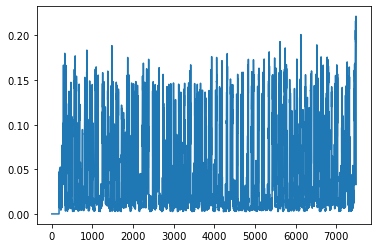

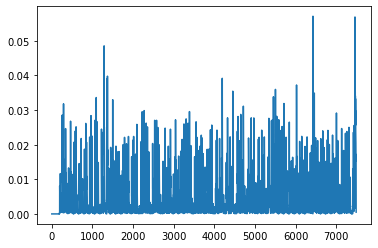

In [243]:
plt.plot(np.arange(myfeats.shape[1]),myfeats[0,:])
plt.show()
plt.plot(np.arange(myfeats.shape[1]),myfeats[1,:])
plt.show()
plt.plot(np.arange(myfeats.shape[1]),myfeats[2,:])
plt.show()
plt.plot(np.arange(myfeats.shape[1]),myfeats[3,:])
plt.show()
plt.plot(np.arange(myfeats.shape[1]),myfeats[4,:])
plt.show()


In [244]:
def comp_acf(inputVector, bIsNormalized = True):
    if bIsNormalized:        
        norm = np.dot(inputVector, inputVector)    
    else:        
        norm = 1    
    afCorr = np.correlate(inputVector, inputVector, "full") / norm    
    afCorr = afCorr[np.arange(inputVector.size-1, afCorr.size)]    
    return (afCorr)

In [245]:
def get_f0_from_acf (r, fs):    
    eta_min = 1    
    afDeltaCorr = np.diff(r)    
    eta_tmp = np.argmax(afDeltaCorr > 0)    
    eta_min = np.max([eta_min, eta_tmp])    
    f = np.argmax(r[np.arange(eta_min + 1, r.size)])    
    f = fs / (f + eta_min + 1)    
    return (f)

In [246]:
def track_pitch_acf(x,blockSize,hopSize,fs):    
    # get blocks    
    [xb,t] = block_audio(x,blockSize,hopSize,fs)    
    # init result    
    f0 = np.zeros(xb.shape[0])    
    # compute acf    
    for n in range(0, xb.shape[0]):
        r = comp_acf(xb[n,:])
        f0[n] = get_f0_from_acf(r,fs)
    
    return (f0,t)

In [247]:
pitches= track_pitch_acf(audio[:,0], 1024, 512, samplerate)

<ipython-input-244-19c8a75a483d>:6: RuntimeWarning: invalid value encountered in true_divide
  afCorr = np.correlate(inputVector, inputVector, "full") / norm


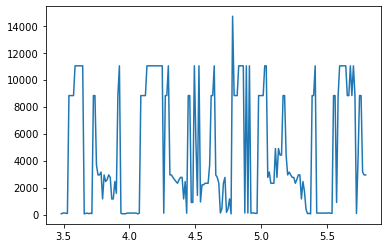

In [248]:
plt.plot(pitches[1][300:500],pitches[0][300:500])

### Compute Energy


In [249]:
def extract_energy(x, blockSize, hopSize, fs):
    xb,t = block_audio(x, blockSize, hopSize, fs)
    block_num = math.ceil(x.size / hopSize)
    energy = np.zeros([1, block_num])

    for i in range(0,block_num):
        mag = np.abs(np.fft.fft(xb[i]))
        energy[0][i] = np.sum(mag**2)
    return energy
        


(7491,)
(7491,)


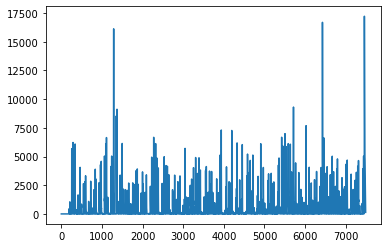

In [250]:
myenergy = extract_energy(audio[:,1], 1024, 512, samplerate)
print(myenergy[0,:].shape)
print(np.arange(myenergy.size).shape)
plt.plot(np.arange(myenergy.size),myenergy[0,:])
plt.show()


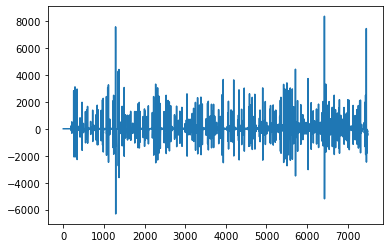

In [251]:
gradientpower = np.gradient(myenergy[0,:])
plt.plot(np.arange(gradientpower.size),gradientpower)
plt.show()

In [252]:
mypeaks,_ = scipy.signal.find_peaks(gradientpower, height = 20)
#height requirement to get total drum hits to about 500 which is about number of drum hits present
print(mypeaks.size)


275


### Apply a bandpass filter

In [202]:
def butter_bandpass(lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


In [228]:
bandpassx = butter_bandpass_filter(audio[:,1], 50, 100, samplerate, 3)
print(bandpassx.shape)

(3373270,)


In [229]:
def plotfft(amplitude, fs):
    fourierTransform = np.fft.fft(amplitude)/len(amplitude)           # Normalize amplitude
    fourierTransform = fourierTransform[range(int(len(amplitude)/2))] # Exclude sampling frequency

    tpCount     = len(amplitude)
    values      = np.arange(int(tpCount/2))
    timePeriod  = tpCount/fs
    frequencies = values/timePeriod
    
    plt.plot(frequencies, abs(fourierTransform))

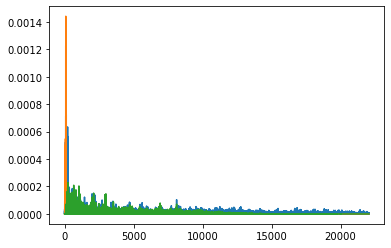

In [230]:
plotfft(audio[:,0],samplerate)
plotfft(bandpassx,samplerate)
bandpassx2 = butter_bandpass_filter(audio[:,1], 300, 10000, samplerate, 3)
plotfft(bandpassx2,samplerate)

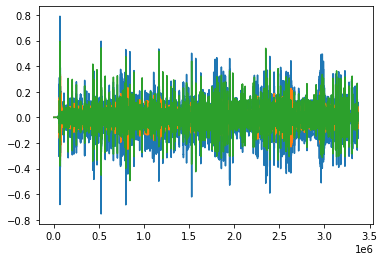

In [233]:
plt.plot(np.arange(audio[:,1].size),audio[:,1]) #blue
plt.plot(np.arange(audio[:,1].size),bandpassx) #orange
plt.plot(np.arange(audio[:,1].size),bandpassx2) #green

In [316]:
#piece 1 funk beat
#should have about 120 kicks
#almost 200 snares
#no toms, but about 20 rim shots (maybe rims shots in snare range?)
#constant hihats, approx 400

#take bandpass of each band
bandpasskick = butter_bandpass_filter(audio[:,1], 40, 100, samplerate3, 3)
bandpasssnare = butter_bandpass_filter(audio[:,1], 176, 230, samplerate3, 3)
bandpasstom = butter_bandpass_filter(audio[:,1], 100, 160, samplerate3, 3)
bandpasshihat = butter_bandpass_filter(audio[:,1], 500, 10000, samplerate3, 3)

kickenergy = extract_energy(bandpasskick, 4096, 2048, samplerate)
kickgradient = np.gradient(kickenergy[0,:])

snareenergy = extract_energy(bandpasssnare, 4096, 2048, samplerate)
snaregradient = np.gradient(snareenergy[0,:])

tomenergy = extract_energy(bandpasstom, 4096, 2048, samplerate)
tomgradient = np.gradient(tomenergy[0,:])

hihatenergy = extract_energy(bandpasshihat, 4096, 2048, samplerate)
hihatgradient = np.gradient(hihatenergy[0,:])

mypeaks,_ = scipy.signal.find_peaks(kickgradient, height = 200)
#height requirement to get total drum hits to right number
print(mypeaks.size)

mypeaks,_ = scipy.signal.find_peaks(snaregradient, height = 50)
#height requirement to get total drum hits to right number
print(mypeaks.size)

mypeaks,_ = scipy.signal.find_peaks(tomgradient, height = 2200)
#height requirement to get total drum hits to right number
print(mypeaks.size)

mypeaks,_ = scipy.signal.find_peaks(hihatgradient, height = 20)
#height requirement to get total drum hits to right number
print(mypeaks.size)

121
106
100
242


In [287]:
#104 funk fill
#take bandpass of each band
bandpasskick = butter_bandpass_filter(audio2[:,1], 60, 100, samplerate2, 3)
bandpasssnare = butter_bandpass_filter(audio2[:,1], 176, 230, samplerate2, 3)
bandpasstom = butter_bandpass_filter(audio2[:,1], 100, 160, samplerate2, 3)
bandpasshihat = butter_bandpass_filter(audio2[:,1], 500, 10000, samplerate2, 3)

kickenergy = extract_energy(bandpasskick, 1024, 512, samplerate)
kickgradient = np.gradient(kickenergy[0,:])

snareenergy = extract_energy(bandpasssnare, 1024, 512, samplerate)
snaregradient = np.gradient(snareenergy[0,:])

tomenergy = extract_energy(bandpasstom, 1024, 512, samplerate)
tomgradient = np.gradient(tomenergy[0,:])

hihatenergy = extract_energy(bandpasshihat, 1024, 512, samplerate)
hihatgradient = np.gradient(hihatenergy[0,:])

mypeaks,_ = scipy.signal.find_peaks(kickgradient, height = 2200)
#height requirement to get total drum hits to right number
print(mypeaks.size)

mypeaks,_ = scipy.signal.find_peaks(snaregradient, height = 2200)
#height requirement to get total drum hits to right number
print(mypeaks.size)

mypeaks,_ = scipy.signal.find_peaks(tomgradient, height = 2200)
#height requirement to get total drum hits to right number
print(mypeaks.size)

mypeaks,_ = scipy.signal.find_peaks(hihatgradient, height = 270)
#height requirement to get total drum hits to right number
print(mypeaks.size)

0
1
7
3


In [291]:
#take bandpass of each band
bandpasskick = butter_bandpass_filter(audio3[:,1], 60, 100, samplerate3, 3)
bandpasssnare = butter_bandpass_filter(audio3[:,1], 176, 230, samplerate3, 3)
bandpasstom = butter_bandpass_filter(audio3[:,1], 100, 160, samplerate3, 3)
bandpasshihat = butter_bandpass_filter(audio3[:,1], 500, 10000, samplerate3, 3)

kickenergy = extract_energy(bandpasskick, 1024, 512, samplerate)
kickgradient = np.gradient(kickenergy[0,:])

snareenergy = extract_energy(bandpasssnare, 1024, 512, samplerate)
snaregradient = np.gradient(snareenergy[0,:])

tomenergy = extract_energy(bandpasstom, 1024, 512, samplerate)
tomgradient = np.gradient(tomenergy[0,:])

hihatenergy = extract_energy(bandpasshihat, 1024, 512, samplerate)
hihatgradient = np.gradient(hihatenergy[0,:])

mypeaks,_ = scipy.signal.find_peaks(kickgradient, height = 3000)
#height requirement to get total drum hits to right number
print(mypeaks.size)

mypeaks,_ = scipy.signal.find_peaks(snaregradient, height = 1500)
#height requirement to get total drum hits to right number
print(mypeaks.size)

mypeaks,_ = scipy.signal.find_peaks(tomgradient, height = 2200)
#height requirement to get total drum hits to right number
print(mypeaks.size)

mypeaks,_ = scipy.signal.find_peaks(hihatgradient, height = 300)
#height requirement to get total drum hits to right number
print(mypeaks.size)

1
2
1
5


### Count percentage of pitches in ranges

In [90]:
high_count = 0
medhigh_count = 0
med_count = 0
medlow_count = 0
low_count = 0

for i in range (0, pitches[1].size):
    if ((pitches[0][i] > 12000) & (pitches[0][i] <= 16000) ):
        high_count = high_count + 1
    if ((pitches[0][i] > 10000) & (pitches[0][i] <= 12000) ):
        medhigh_count = medhigh_count + 1
    if ((pitches[0][i] > 6000) & (pitches[0][i] <= 10000) ):
        med_count = med_count + 1
    if ((pitches[0][i] > 1000) & (pitches[0][i] <= 6000) ):
        medlow_count = medlow_count + 1
    if ((pitches[0][i] > 0) & (pitches[0][i] <= 1000) ):
        low_count = low_count + 1
            

In [95]:
percent = np.zeros(5)
percent[0] = high_count / pitches[1].size
percent[1] = medhigh_count / pitches[1].size
percent[2] = med_count / pitches[1].size
percent[3] = medlow_count / pitches[1].size
percent[4] = low_count / pitches[1].size

In [96]:
print(percent)

[0.03070351 0.16860232 0.1525831  0.26992391 0.3525564 ]


### Try again with different genres

<ipython-input-41-e2d6b343da85>:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  [samplerate, x] = wavread(cAudioFilePath)
<ipython-input-55-19c8a75a483d>:6: RuntimeWarning: invalid value encountered in true_divide
  afCorr = np.correlate(inputVector, inputVector, "full") / norm


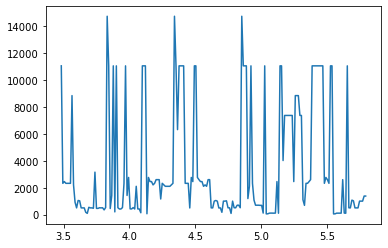

In [97]:
samplerate,audio = ToolReadAudio('./groove/drummer1/session1/4_jazz-funk_116_beat_4-4.wav')
pitches= track_pitch_acf(audio[:,0], 1024, 512, samplerate)
plt.plot(pitches[1][300:500],pitches[0][300:500])

In [98]:
high_count = 0
medhigh_count = 0
med_count = 0
medlow_count = 0
low_count = 0

for i in range (0, pitches[1].size):
    if ((pitches[0][i] > 12000) & (pitches[0][i] <= 16000) ):
        high_count = high_count + 1
    if ((pitches[0][i] > 10000) & (pitches[0][i] <= 12000) ):
        medhigh_count = medhigh_count + 1
    if ((pitches[0][i] > 6000) & (pitches[0][i] <= 10000) ):
        med_count = med_count + 1
    if ((pitches[0][i] > 1000) & (pitches[0][i] <= 6000) ):
        medlow_count = medlow_count + 1
    if ((pitches[0][i] > 0) & (pitches[0][i] <= 1000) ):
        low_count = low_count + 1

        
percent = np.zeros(5)
percent[0] = high_count / pitches[1].size
percent[1] = medhigh_count / pitches[1].size
percent[2] = med_count / pitches[1].size
percent[3] = medlow_count / pitches[1].size
percent[4] = low_count / pitches[1].size

print(percent)

[0.01274852 0.1127637  0.0427986  0.42662012 0.39216877]


### Functionalize it all

In [99]:
def PitchPercents(path):
    samplerate,audio = ToolReadAudio(path)
    pitches= track_pitch_acf(audio[:,0], 1024, 512, samplerate)
    
    high_count = 0
    medhigh_count = 0
    med_count = 0
    medlow_count = 0
    low_count = 0

    for i in range (0, pitches[1].size):
        if ((pitches[0][i] > 12000) & (pitches[0][i] <= 16000) ):
            high_count = high_count + 1
        if ((pitches[0][i] > 10000) & (pitches[0][i] <= 12000) ):
            medhigh_count = medhigh_count + 1
        if ((pitches[0][i] > 6000) & (pitches[0][i] <= 10000) ):
            med_count = med_count + 1
        if ((pitches[0][i] > 1000) & (pitches[0][i] <= 6000) ):
            medlow_count = medlow_count + 1
        if ((pitches[0][i] > 0) & (pitches[0][i] <= 1000) ):
            low_count = low_count + 1
            
    percent = np.zeros(5)
    percent[0] = high_count / pitches[1].size
    percent[1] = medhigh_count / pitches[1].size
    percent[2] = med_count / pitches[1].size
    percent[3] = medlow_count / pitches[1].size
    percent[4] = low_count / pitches[1].size   

    return percent

In [118]:
print(np.vstack((PitchPercents('./groove/drummer1/session1/4_jazz-funk_116_beat_4-4.wav'),PitchPercents('./groove/drummer1/session1/5_jazz-funk_116_beat_4-4.wav'))).shape)


<ipython-input-41-e2d6b343da85>:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  [samplerate, x] = wavread(cAudioFilePath)
<ipython-input-55-19c8a75a483d>:6: RuntimeWarning: invalid value encountered in true_divide
  afCorr = np.correlate(inputVector, inputVector, "full") / norm


(2, 5)


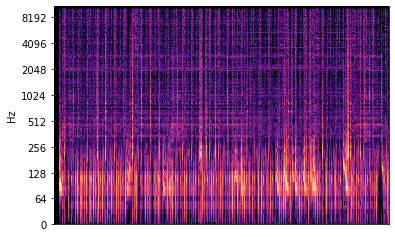

In [218]:
y, sr = librosa.load('./groove/drummer1/session1/4_jazz-funk_116_beat_4-4.wav')
D = librosa.stft(y)  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
plt.figure()
librosa.display.specshow(S_db,y_axis='log')

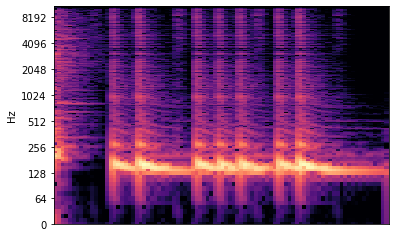

In [258]:
y, sr = librosa.load('./groove/drummer1/session1/13_jazz-funk_116_fill_4-4.wav')
D = librosa.stft(y)  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
plt.figure()
librosa.display.specshow(S_db,y_axis='log')

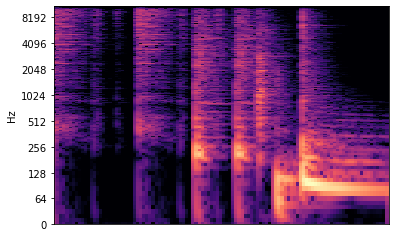

In [289]:
y, sr = librosa.load('./groove/drummer1/session1/104_funk_95_fill_4-4.wav')
D = librosa.stft(y)  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
plt.figure()
librosa.display.specshow(S_db,y_axis='log')

### Do it for a whole folder

In [133]:
def PitchPercentsFolder(folderpath):
    x = 0
    for file in os.listdir(folderpath):
        if file.endswith(".wav"):
          
            if x == 0:
                ArrPercents = PitchPercents(folderpath + '/' + file)
                Arrfiles = file
                x = 1
            else:
                ArrPercents = np.vstack((ArrPercents, PitchPercents(folderpath + '/' + file)))
                Arrfiles = np.vstack((Arrfiles,file))
                
    return ArrPercents, Arrfiles

In [134]:
myPercents = PitchPercentsFolder('./groove/drummer1/session1')[0]
myTitles = PitchPercentsFolder('./groove/drummer1/session1')[1]

<ipython-input-41-e2d6b343da85>:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  [samplerate, x] = wavread(cAudioFilePath)
<ipython-input-55-19c8a75a483d>:6: RuntimeWarning: invalid value encountered in true_divide
  afCorr = np.correlate(inputVector, inputVector, "full") / norm


In [135]:
print(myPercents.shape)

(268, 5)


<ipython-input-217-e23525dd053a>:5: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  ax1.pie(sizes, labels=labels, autopct='%1.1f%%',


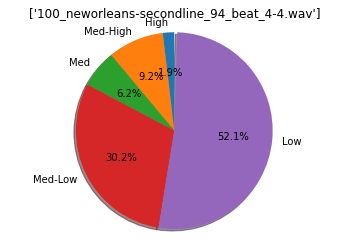

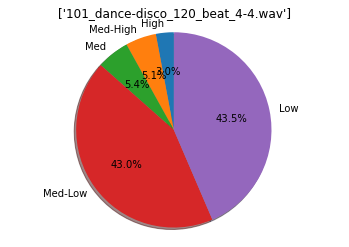

In [217]:
for x in range(0,2):    
    sizes = myPercents[x,:]
    labels = 'High', 'Med-High', 'Med', 'Med-Low', 'Low'
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
    shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(myTitles[x])
    
    plt.show()